In [25]:
from bs4 import BeautifulSoup
import requests
import json

header = {
    'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36'
}

def fetch_link_list(sid):
    '''뉴스 카테고리 5페이지의 URL 목록 return'''
    cursor = 0
    link_list = []
    for _ in range(2):
        URL = f'https://news.naver.com/section/template/SECTION_ARTICLE_LIST?sid={sid}&next={cursor}'
        
        response = requests.get(URL, headers=header)
        datas = response.json()
        text = datas['renderedComponent']['SECTION_ARTICLE_LIST']
        soup = BeautifulSoup(text,'html.parser')

        # '더보기' 헤드에 있는 뉴스로 cursor 변경
        cursor = soup.select_one('div._PERSIST_META')['data-cursor']

        # cursor가 가리키는 뉴스로부터 1페이지 분량 URL 추출
        links = soup.select('a.sa_thumb_link')
        link_list += [link.attrs['href'] for link in links]

    return link_list

def fetch_summary_data(article_url):
    '''뉴스의 AI 요약봇의 제목, 본문을 dictionary형으로 return'''
    parts = article_url.split('/')
    extracted_part = f'{parts[5]}/{parts[6]}'
    extracted_part
    URL = f'https://tts.news.naver.com/article/{extracted_part}/summary?callback=callback&JSON'

    response = requests.get(URL, headers=header)
    fetchs = BeautifulSoup(response.text, 'html.parser')
    json_string = response.text.replace("/**/callback(","")[:-2]
    summary_bot = json.loads(json_string)

    news_data = {
    '제목' : summary_bot["title"],
    'AI 요약': summary_bot["summary"].replace("<br/><br/>","")
}
    return news_data


result = [fetch_summary_data(article) for article in fetch_link_list(100)]

# 수집한 데이터를 JSON 파일(news_crawl_bs.json)로 저장
with open('summary_crawl_bs.json', 'w', encoding='utf-8') as file:
    json.dump(result, file, indent=4, ensure_ascii=False)
    

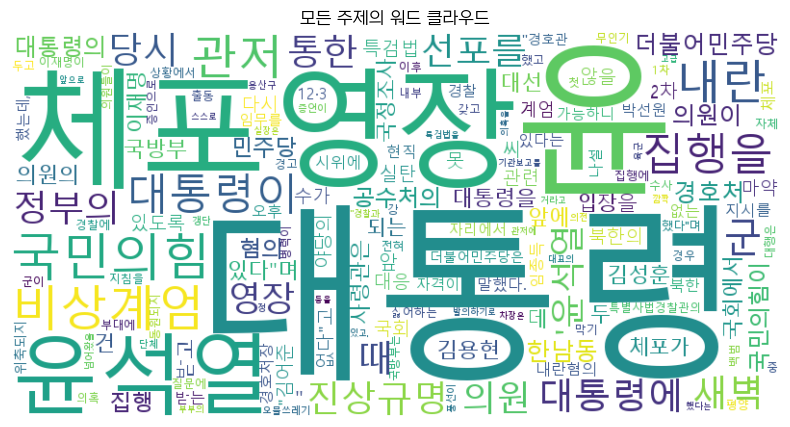

In [47]:
import json
from gensim import corpora
from gensim.models import LdaModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt

with open('summary_crawl_bs.json', 'r', encoding='utf-8') as json_file:
    articles = json.load(json_file)

    # 한글 폰트 설정 (전역)
    plt.rc('font', family='NEXON Lv1 Gothic OTF')
    # 마이너스 폰트 깨짐 방지
    plt.rcParams['axes.unicode_minus'] = False

    # 불용어 리스트 정의
    stop_words = [
            '은', '는', '이', '가', '의', '에', '에서', '과', '와', '도', '로',
            '아', '야', '한', '한테', '에게', '나', '너', '그', '그녀', '이',
            '저', '우리', '그들', '당신', '이들', '그', '저', '이것', '저것',
            '이런', '그런', '아무', '모든', '어떤', '누구', '어느', '왜',
            '어떻게', '무엇', '뭐', '그러다', '하다', '있다', '없다', '되다',
            '가다', '오다', '보다', '주다',
            '오늘', '내일', '어제', '지금', '언제', '시간', '년', '월', '일',
            '그리고', '하지만', '또는', '그럼', '그래서', '즉', '그러나', '또한', '뿐만 아니라', '이외에도',
            '윤건영', '전', '허', '있는', '수', '대표가', '대표는', '최', '김', '게', '안', '의원은', '좀', '것으로',
            '있다고', '것', '대한', '저는', '있다고', '이제', '를', '것으로', '등', '당', '지난', '통해',
            '이날','한다"고','있다','할','위해','했다','했다고','겸','했는지','이렇게','놓고','하고','것은','있을','다른',
            '이게','있고','될','대해','했다','있다"고','찾아','같은','측은','하고','놓고','것을','향해','대해','년','월',
            '1일', '2일', '3일', '4일', '5일', '6일', '7일', '8일', '9일', '10일',
            '11일', '12일', '13일', '14일', '15일', '16일', '17일', '18일', '19일', '20일',
            '21일', '22일', '23일', '24일', '25일', '26일', '27일', '28일', '29일', '30일', '31일', '대통령이' '은', '는', '이',
            '가', '의', '에', '에서', '과', '와', '도', '로',
            '오늘', '내일', '어제', '지금', '언제', '시간', '년', '월', '일',
            '그리고', '하지만', '또는', '그럼', '그래서', '즉', '그러나', '또한', '뿐만 아니라', '이외에도',
            '윤건영', '전', '허', '있는', '수', '대표가', '대표는', '최', '김', '게', '안', '의원은', '좀', '것으로',
            '있다고', '것', '대한', '저는', '있다고', '이제', '를', '것으로', '등', '당', '이렇게', '제가',
            '것이', ':', '때문에', '그러니까', '하는', '있습니다.', '할', '있다.', '>', '하고', '또', '다'
            '대해서', '우리가', '그렇게', '그러면', '될', '같은', '많이', '근데', '하면', '그냥', '가지고', '거',
            '것은', '거예요.', '해야', '그런데','지난해','따르면','이라고','올해','위해'
        ]
        
    # JSON 파일 로드
    with open('summary_crawl_bs.json', 'r', encoding='utf-8') as json_file:
        articles = json.load(json_file)
    # 문서 전처리
    texts = []
    for article in articles:
        # 내용에서 불용어 제거 및 토큰화
        tokens = article['AI 요약'].split()
        tokens = [word for word in tokens if word not in stop_words]
        texts.append(tokens)

    # 단어 사전 생성
    dictionary = corpora.Dictionary(texts)

    # 문서-단어 행렬 생성
    corpus = [dictionary.doc2bow(text) for text in texts]

    # LDA 모델 학습
    lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

    # 모든 주제의 워드 클라우드를 하나의 이미지로 합치기
    combined_wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        font_path='C:/Windows/Fonts/malgun.ttf'  # Malgun Gothic 폰트 경로
    )

    # 각 주제의 단어 빈도를 합산
    combined_frequencies = {}

    for i in range(lda_model.num_topics):
        word_dict = dict(lda_model.show_topic(i, topn=50))  # 각 주제의 상위 50개 단어
        for word, freq in word_dict.items():
            if word in combined_frequencies:
                combined_frequencies[word] += freq
            else:
                combined_frequencies[word] = freq

    # 합쳐진 단어 빈도로 워드 클라우드 생성
    combined_wordcloud.generate_from_frequencies(combined_frequencies)

    # 워드 클라우드 시각화
    plt.figure(figsize=(13, 7))
    plt.imshow(combined_wordcloud, interpolation='bilinear')
    plt.axis('off')  # 축 표시 제거
    plt.title('모든 주제의 워드 클라우드')
    plt.show()

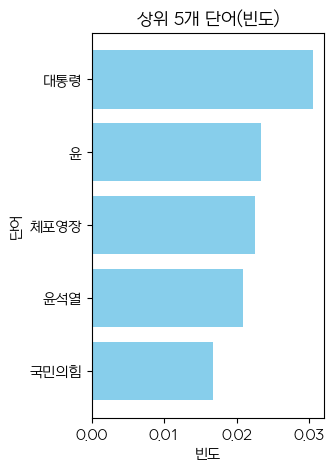

In [48]:
import matplotlib.pyplot as plt

def cloud_Frequency():
# 상위 5개 단어 출력
top_n = 5
sorted_frequencies = sorted(combined_frequencies.items(), key=lambda x: x[1], reverse=True)  # 빈도수 기준으로 정렬
top_words = sorted_frequencies[:top_n]  # 상위 5개 단어 선택

# 상위 5개 단어와 빈도 분리
words, frequencies = zip(*top_words)

# 빈도를 역순으로 정렬
words = list(reversed(words))
frequencies = list(reversed(frequencies))

# 가로 바 차트 그리기
plt.figure(figsize=(3, 5))
plt.barh(words, frequencies, color='skyblue')
plt.title('상위 5개 단어(빈도)')
plt.xlabel('빈도')
plt.ylabel('단어')
plt.show()